In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import requests

import pandas as pd
import random
import numpy as np

covid_path = os.path.join('/content','drive','My Drive','covid')


In [26]:
rilevazioni = pd.read_csv('/content/drive/My Drive/IT/Python/covid/rilevazioni.csv').set_index(['Regione','Citta'])
rilevazioni.iloc[:,15:]

23-03  24-03  25-03  ...  05-04  06-04  07-04
Regione   Citta                                 ...                     
LOMBARDIA BERGAMO           6471   6728   7072  ...   9712   9815   9868
          BRESCIA           5905   6298   6597  ...   9340   9477   9594
          COMO               581    635    706  ...   1384   1473   1525
          CREMONA           2925   3061   3156  ...   4233   4260   4323
          LECCO              934   1015   1076  ...   1678   1712   1731
...                          ...    ...    ...  ...    ...    ...    ...
CALABRIA  COSENZA             68     84     99  ...    230    243    254
          REGGIO CALABRIA     94     97    105  ...    237    243    243
          CATANZARO           46     49     51  ...    157    158    162
          VIBO VALENTIA       20     21     23  ...     60     60     60
          CROTONE             62     66     71  ...    109    111    112

[108 rows x 16 columns]

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

def plot_annotate(df, title='', xdelta=0, ydelta=10, figsize=(17, 7)):
  
  ax = df.T.plot(figsize=figsize, title=title)
  ax.set_xticks(ticks=np.arange(0, len(df.columns), step=2))
  tick_label = list(df.columns)[::2]
  ax.set_xticklabels(tick_label)

  for k, v in zip(np.arange(len(df.columns)), df.T.iterrows()):
    for el in v[1]:
      ax.annotate(el, (k + xdelta, el + ydelta))
  return ax

In [0]:
sorted_by_infections = rilevazioni.loc[rilevazioni.sort_values(by=[rilevazioni.columns[-1]],ascending=False).index]

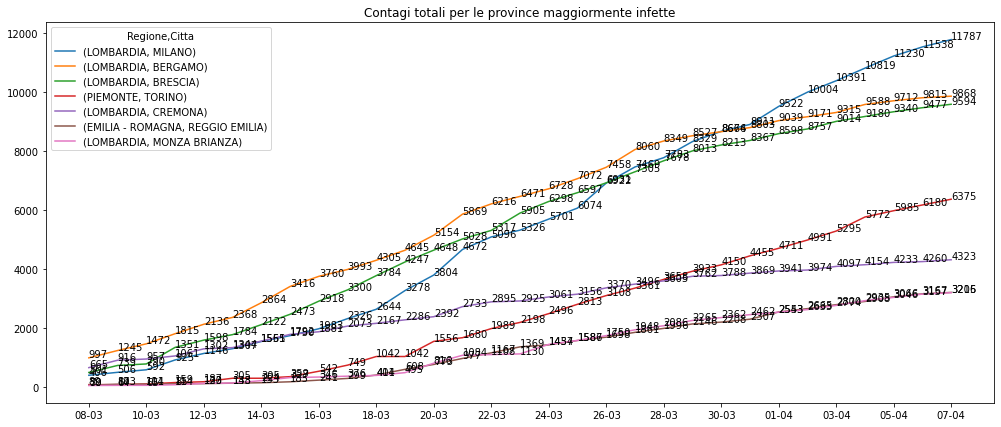

In [29]:
_ = plot_annotate(sorted_by_infections.head(7),'Contagi totali per le province maggiormente infette')

In [0]:
crescita = pd.DataFrame(index=sorted_by_infections.index)

In [0]:
for ieri, oggi in zip(sorted_by_infections.columns[:-1], sorted_by_infections.columns[1:]):
  crescita[oggi] = sorted_by_infections[oggi] - sorted_by_infections[ieri]

In [32]:
display(crescita.head(3))
sorted_by_infections.head(3)

09-03  10-03  11-03  12-03  ...  04-04  05-04  06-04  07-04
Regione   Citta                                ...                            
LOMBARDIA MILANO     100     86    333    221  ...    428    411    308    249
          BERGAMO    248    227    343    321  ...    273    124    103     53
          BRESCIA    238     51    561    247  ...    166    160    137    117

[3 rows x 30 columns]

08-03  09-03  10-03  11-03  ...  04-04  05-04  06-04  07-04
Regione   Citta                                ...                            
LOMBARDIA MILANO     406    506    592    925  ...  10819  11230  11538  11787
          BERGAMO    997   1245   1472   1815  ...   9588   9712   9815   9868
          BRESCIA    501    739    790   1351  ...   9180   9340   9477   9594

[3 rows x 31 columns]

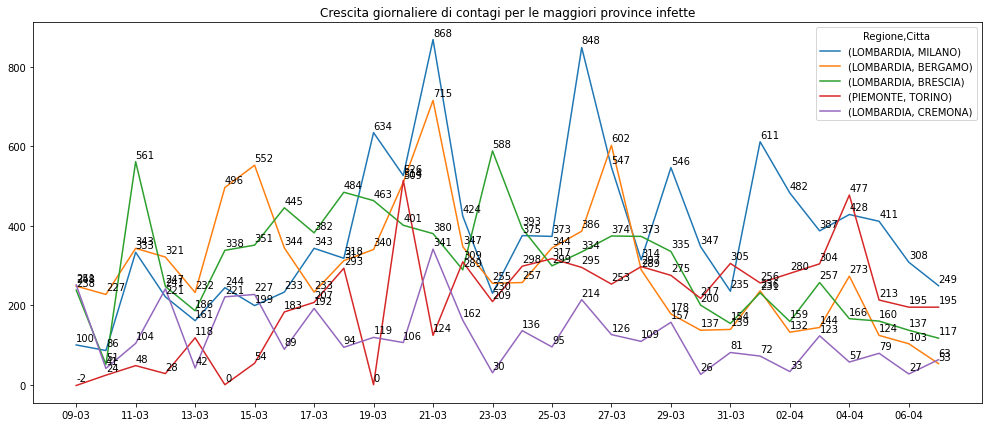

In [33]:
_ = plot_annotate(crescita.head(5), 'Crescita giornaliere di contagi per le maggiori province infette')

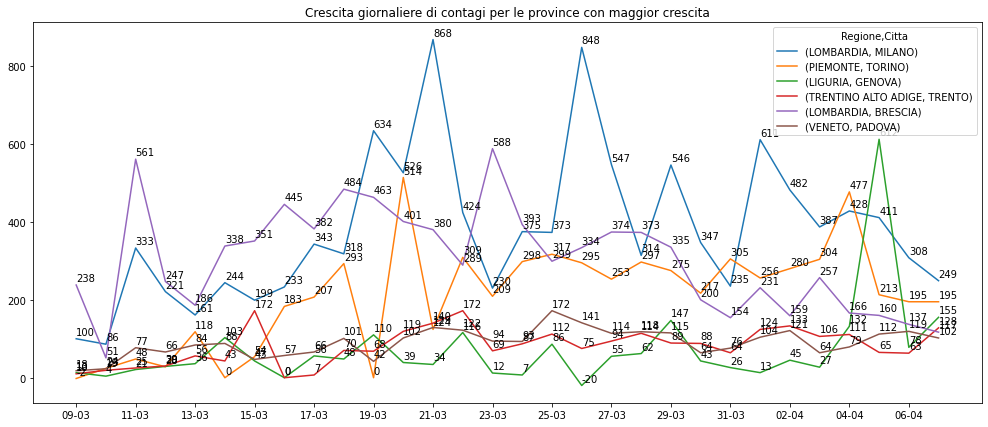

In [34]:
ax = plot_annotate(crescita.sort_values(by=crescita.columns[-1], ascending=False).head(6),
                   'Crescita giornaliere di contagi per le province con maggior crescita')
#_ = ax.set_ylim(-111,ax.get_ylim()[1])

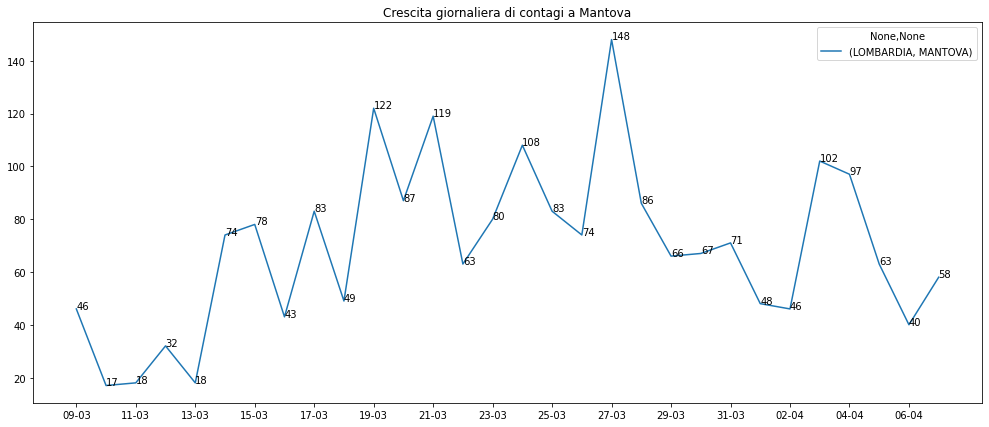

In [35]:
_ = plot_annotate(crescita.loc[('LOMBARDIA','MANTOVA')].to_frame().T, 'Crescita giornaliera di contagi a Mantova', ydelta=0)

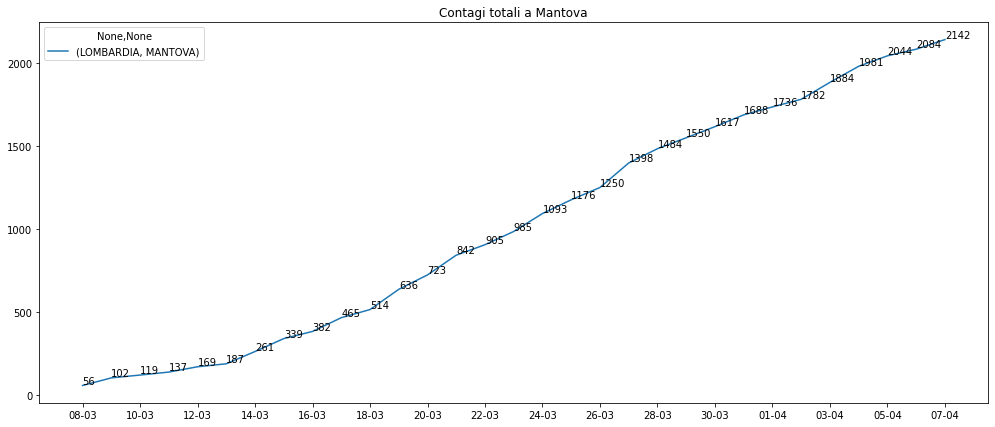

In [36]:
_ = plot_annotate(sorted_by_infections.loc[('LOMBARDIA','MANTOVA')].to_frame().T, 'Contagi totali a Mantova')

# Average 3 days

In [0]:
avg3 = pd.DataFrame(index=sorted_by_infections.index)
for meno2,ieri, oggi in zip(crescita.columns[:-2], crescita.columns[1:-1], crescita.columns[2:]):
  avg3[oggi] = pd.concat([crescita[oggi], crescita[ieri], crescita[meno2]], axis=1).mean(axis=1)

In [0]:
avg3 = avg3.astype('int32')

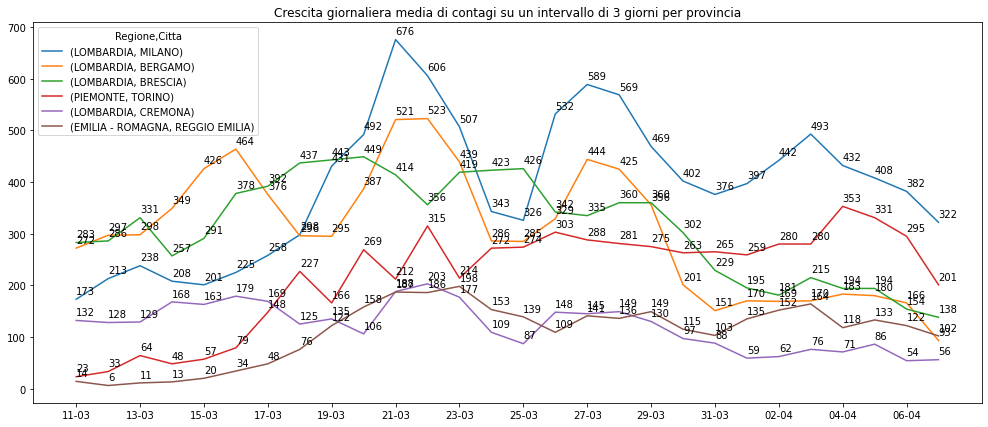

In [39]:
_ = plot_annotate(avg3.head(6), 'Crescita giornaliera media di contagi su un intervallo di 3 giorni per provincia')

In [0]:
casi_italia = sorted_by_infections.sum(axis=0).to_frame().T
casi_italia.index= ['Italia']

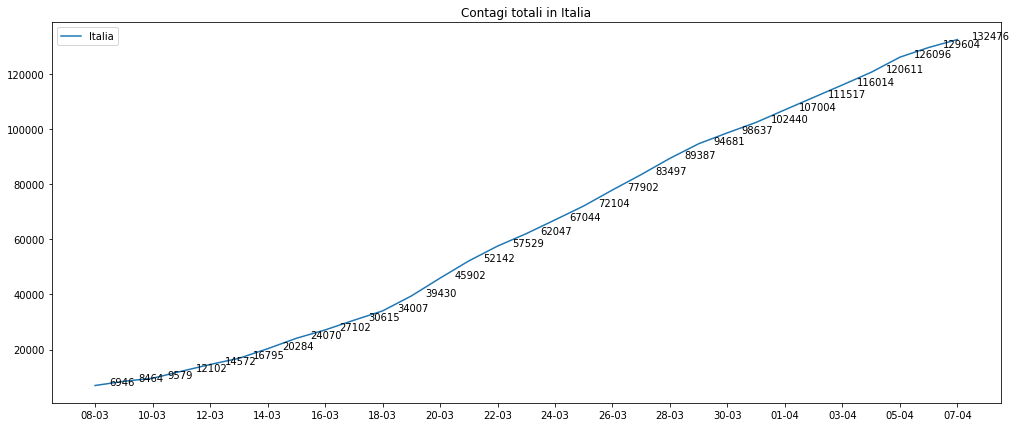

In [41]:
_ = plot_annotate(casi_italia, 'Contagi totali in Italia', xdelta=0.5)

In [0]:
crescita_italia = crescita.sum().to_frame().T
crescita_italia.index = ['Italia']

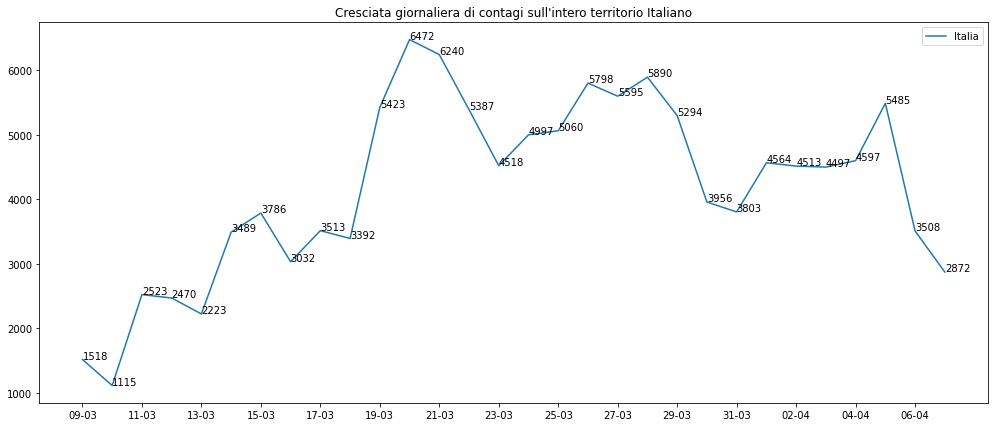

In [43]:
_ = plot_annotate(crescita_italia, 'Cresciata giornaliera di contagi sull\'intero territorio Italiano')

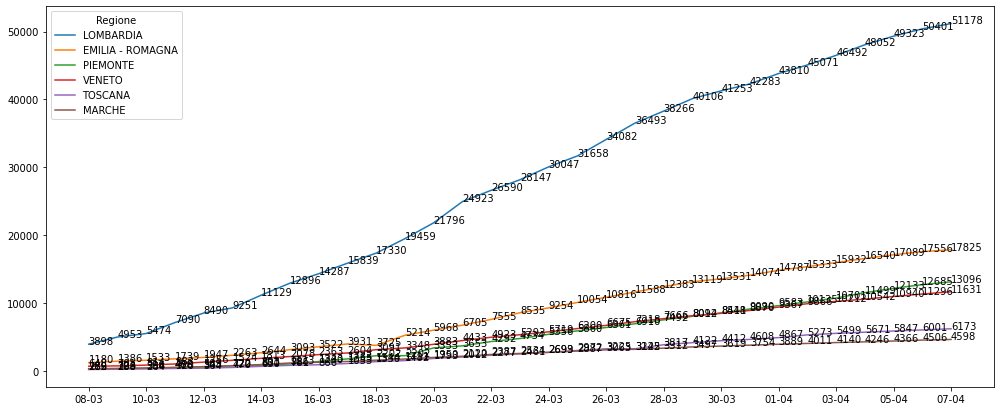

In [44]:
regioni = sorted_by_infections.groupby('Regione').sum()
regioni = regioni.sort_values(by=[regioni.columns[-1]],ascending=False)
_ = plot_annotate(regioni.head(6))

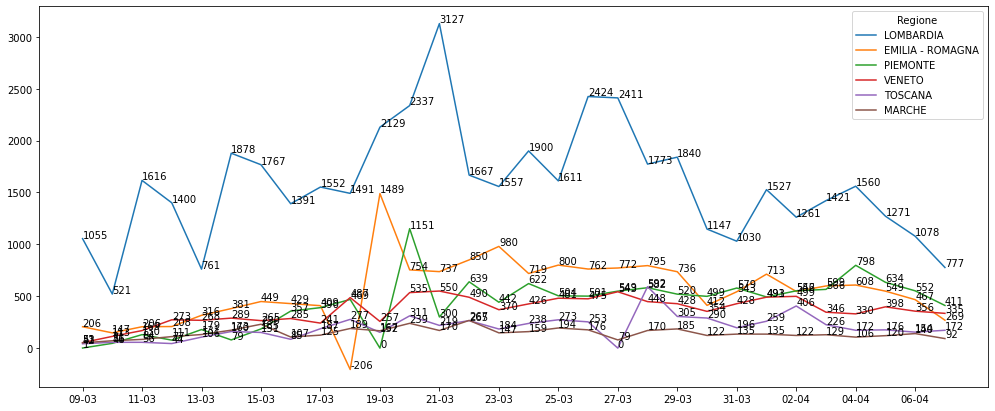

In [45]:
crescita_regioni = crescita.groupby('Regione').sum().loc[regioni.index]
_ = plot_annotate(crescita_regioni.head(6))
